In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import cv2
from tqdm import tqdm

from multiprocessing import Pool, cpu_count

from subprocess import check_output
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from keras.callbacks import LambdaCallback, EarlyStopping
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv('inputs/train_v2.csv')
print("Number of records in Training set %d" % len(df_train))
df_train.head(2)

Number of records in Training set 40479


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water


In [3]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}
print(labels)

['slash_burn', 'clear', 'blooming', 'primary', 'cloudy', 'conventional_mine', 'water', 'haze', 'cultivation', 'partly_cloudy', 'artisinal_mine', 'habitation', 'bare_ground', 'blow_down', 'agriculture', 'road', 'selective_logging']


In [5]:
input_dir = 'inputs'
subset_size = 1000
img_size = 128
tag_of_interest = 'agriculture'
np.random.seed(0)
X = []
Y = []
for f, tags in tqdm(df_train.values, miniters=1000):
    f_name = '{}.jpg'.format(f)
    img = cv2.imread(os.path.join(input_dir, 'train-jpg', f_name))
    targets = np.array([1,0])
    if tag_of_interest in tags:
        targets = np.array([0,1])
    X.append(cv2.resize(img, (img_size, img_size)))
    Y.append(targets)

X = np.array(X, np.float16) / 255.
Y = np.array(Y, np.uint8)

print(X.shape)
print(Y.shape)

100%|██████████| 40479/40479 [00:32<00:00, 1235.09it/s]


(40479, 128, 128, 3)
(40479, 2)


In [6]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=0)

In [46]:
len(Y_valid[Y_valid[:,1]==1])

2430

In [45]:
len(Y[Y[:,1]==1])

12315

In [21]:
float(len(Y[Y[:,1]==1]))/len(Y)

0.3042318239086934

In [22]:
def create_deep_model():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(img_size,img_size,3)))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (2, 2), padding='same', activation='relu'))
    model.add(Conv2D(512, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [11]:
def create_model():
    # Create small model for reference
    model = Sequential()
    model.add(Conv2D(32, (3, 3), strides=2, activation='relu', input_shape=(img_size, img_size, 3)))
    model.add(Dropout(0.1))
    model.add(Conv2D(64, (3, 3), strides=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.25))
    # model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.25))
    model.add(Dense(17, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    return model

In [38]:
np.random.seed(0)
batch_size = 256
epochs = 40
scores = []

def my_callback_func(batch,logs):
    p_valid = model.predict(X_valid, batch_size=batch_size,verbose=2)
    score = fbeta_score(Y_valid, (np.array(p_valid) > 0.2).astype(int), beta=2, average=None)
    scores.append(score)


my_callback = LambdaCallback(on_epoch_end=lambda batch,logs: my_callback_func(batch,logs))
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=0)
callbacks = [my_callback, early_stop]

model = create_deep_model()
history_callback = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=2,
          validation_data=(X_valid, Y_valid), callbacks=callbacks, class_weight={0:1, 1:3})

print("Max class score %f at epoch %d" % (np.array(scores)[:,1].max(), np.array(scores)[:,1].argmax()))
print("Max non class score %f at epoch %d" % (np.array(scores)[:,0].max(), np.array(scores)[:,0].argmax()))

Train on 32383 samples, validate on 8096 samples
Epoch 1/40
67s - loss: 1.1186 - acc: 0.6322 - val_loss: 0.5791 - val_acc: 0.6217
Epoch 2/40
66s - loss: 0.8816 - acc: 0.7005 - val_loss: 0.6414 - val_acc: 0.6202
Epoch 3/40
68s - loss: 0.7802 - acc: 0.7461 - val_loss: 0.4684 - val_acc: 0.7510
Epoch 4/40
68s - loss: 0.6996 - acc: 0.7734 - val_loss: 0.6729 - val_acc: 0.7396
Epoch 5/40
67s - loss: 0.6400 - acc: 0.8140 - val_loss: 0.4157 - val_acc: 0.8413
Epoch 6/40
67s - loss: 0.6257 - acc: 0.8244 - val_loss: 0.3956 - val_acc: 0.8372
Epoch 7/40
67s - loss: 0.5786 - acc: 0.8337 - val_loss: 0.4132 - val_acc: 0.8371
Epoch 8/40
68s - loss: 0.5644 - acc: 0.8428 - val_loss: 0.4058 - val_acc: 0.8466
Epoch 9/40
68s - loss: 0.5535 - acc: 0.8460 - val_loss: 0.3585 - val_acc: 0.8568
Epoch 10/40
68s - loss: 0.5436 - acc: 0.8480 - val_loss: 0.3523 - val_acc: 0.8513
Epoch 11/40
68s - loss: 0.5368 - acc: 0.8531 - val_loss: 0.3274 - val_acc: 0.8668
Epoch 12/40
68s - loss: 0.5145 - acc: 0.8576 - val_loss: 0

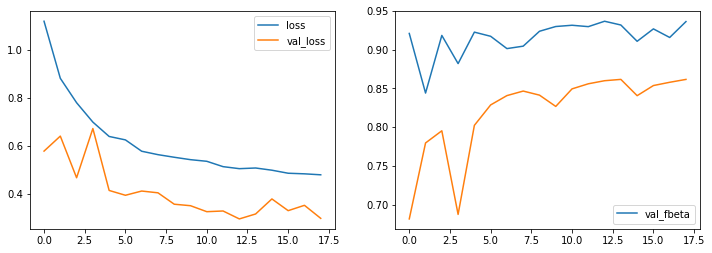

In [39]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_callback.history['loss'])
plt.plot(history_callback.history['val_loss'])
plt.legend(labels=['loss', 'val_loss'])
plt.subplot(1, 2, 2)
plt.plot(scores)
plt.legend(labels=['val_fbeta'])
# plt.show()

In [40]:
p_valid = model.predict(X_valid, batch_size=batch_size,verbose=2).squeeze()
p_valid = (p_valid > 0.2).astype(int)

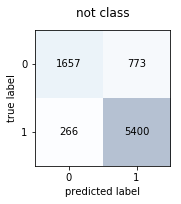

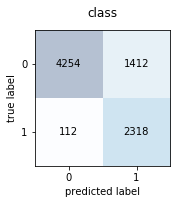

In [43]:
titles = ['not class', 'class']
for i in range(2):
    cm = confusion_matrix(y_target=Y_valid[:,i], 
                      y_predicted=p_valid[:,i], binary=False)
    _, ax = plot_confusion_matrix(conf_mat=cm)
    ax.set_title(titles[i])

In [47]:
def find_ratios(y_true, y_pred, num_classes=2):
    scores = np.zeros(num_classes)
    rat = np.zeros(num_classes)
    step = 0.05
    n = int(1/step)
    for j in range(num_classes):
        r = step
        for i in range(n):
            score = fbeta_score(y_true[:,j], (y_pred[:,j] > r).astype(int), beta=2)
            if score > scores[j]:
                scores[j] = score
                rat[j] = r
            r+=step
    rat[rat == 0] = step
    return rat

In [48]:
p_valid = model.predict(X_valid, batch_size=batch_size,verbose=2)
rat = find_ratios(Y_valid, p_valid)
rat

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



array([ 0.1 ,  0.25])

In [49]:
for i in range(2):
    print("%s: %f" % (titles[i], fbeta_score(Y_valid[:,i], (p_valid[:,i] > rat[i]).astype(int), beta=2)))
print("Average score %f" % fbeta_score(Y_valid, (p_valid > rat).astype(int), beta=2, average='samples'))

not class: 0.941499
class: 0.865559
Average score 0.922390


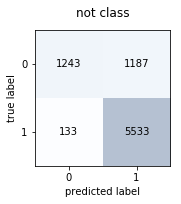

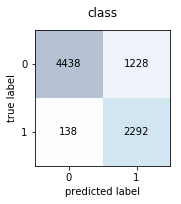

In [50]:
titles = ['not class', 'class']
for i in range(2):
    cm = confusion_matrix(y_target=Y_valid[:,i], 
                      y_predicted=(p_valid[:,i] > rat[i]).astype(int), binary=False)
    _, ax = plot_confusion_matrix(conf_mat=cm)
    ax.set_title(titles[i])

In [44]:
tp = X_valid[(p_valid == Y_valid) & (p_valid == 1)]
tn = X_valid[(p_valid == Y_valid) & (p_valid == 0)]
fp = X_valid[(p_valid != Y_valid) & (p_valid == 1)]
fn = X_valid[(p_valid != Y_valid) & (p_valid == 0)]
print(tp.shape)
print(tn.shape)
print(fp.shape)
print(fn.shape)

(7718, 128, 3)
(5911, 128, 3)
(2185, 128, 3)
(378, 128, 3)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning:

boolean index did not match indexed array along dimension 1; dimension is 128 but corresponding boolean dimension is 2

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning:

boolean index did not match indexed array along dimension 1; dimension is 128 but corresponding boolean dimension is 2

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning:

boolean index did not match indexed array along dimension 1; dimension is 128 but corresponding boolean dimension is 2

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning:

boolean index did not match indexed array along dimension 1; dimension is 128 but corresponding boolean dimension is 2



In [36]:
def show_examples(data, num, cols = 4, zoom=2):
    import math
    from matplotlib.pyplot import imshow
    rows = int(math.ceil(num/cols))
    _, ax = plt.subplots(rows, cols, figsize=(cols*zoom, rows*zoom))
    for i in range(num):
        if len(ax.shape) > 1:
            ax[i // cols, i % cols].imshow((255*data[i]).astype(np.uint8))
        else:
            ax[i].imshow((255*data[i]).astype(np.uint8))

True positives


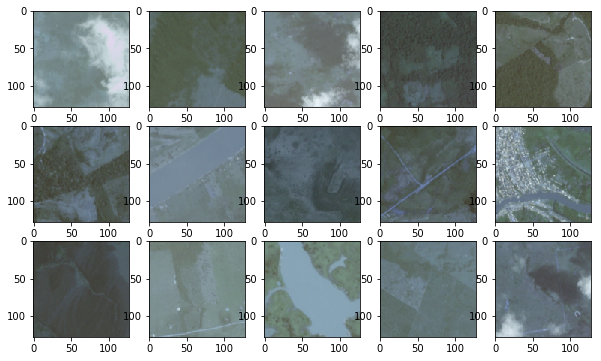

In [37]:
print("True positives")
show_examples(tp, 15, cols=5, zoom=2)

True negative


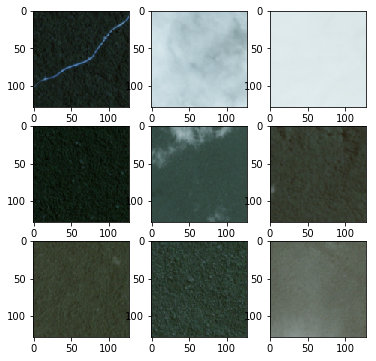

In [38]:
print("True negative")
show_examples(tn, 9, cols=3, zoom=2)

False positives


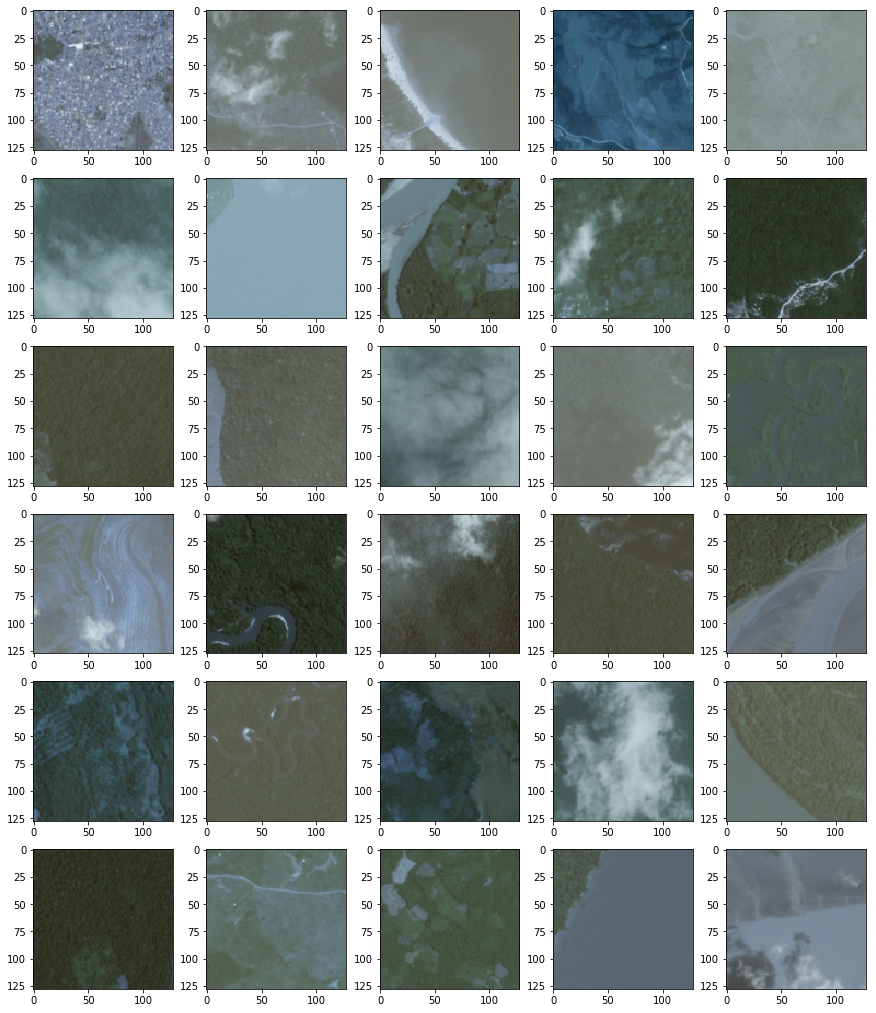

In [39]:
print("False positives")
show_examples(fp, 30, cols=5, zoom=3)

False negative


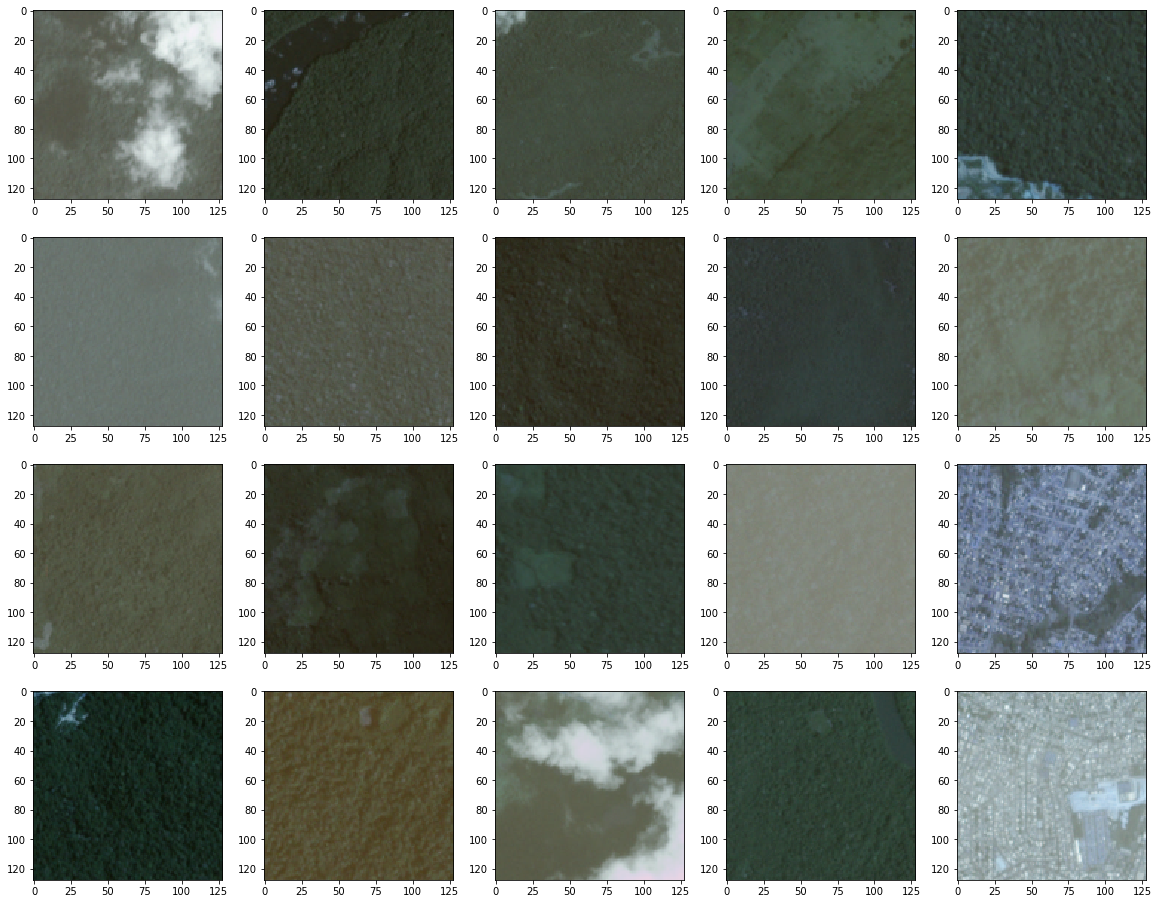

In [41]:
print("False negative")
show_examples(fn, 20, cols=5, zoom=4)

In [ ]:
# Cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = []
for train, val in kfold.split(X, Y):
    model = create_model()